# Inference in the Stochastic Block Model with a Markovian assignment of the communities

In [ ]:
import markovianSBM
from markovianSBM.SBM import SBM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Introduction


The Stochastic Block Model (SBM) is a famous random graph model where a community in $[K]=\{1, \dots , K\}$ (where $K\geq 2$ is an integer) is assigned to each node $i \in [n]$ of a graph. Once the communities have been assigned, an edge between a given pair of vertices will be present in the graph with a probabililty that only depends of the communities of the two nodes considered. \\ We propose a new extension of the Stochastic Block Model where the communities of the nodes in the graph are assigned through a Markovian dynamic. In our paper, we provide a partial recovery bound : We prove that the algorithm leads to a classification error that decays exponentially fast with respect to an appropriate signal to noise ratio (SNR). We provide consistent estimation of the parameters of our model when the average degree of the nodes is of order $\log(n)$ or higher.


In the following, we give the reader the opportunity to understand how to use our algorithm that we have implemented
and to reproduce results that have been presented in our paper.


# 1) Model


We start by ordering the $n$ nodes in $V$ and without loss of generality, we consider the increasing order of the integers $1,2, \dots,n$. For all $i \in [n]$, we denote $C_i \in [K]$ the random variable representing the community of the node $i$ and we consider that they satistify the following assumption. $(C_i)_{i  \in [n]}$ is a positive recurrent Markov chain on the finite space $[K]$ with invariant probability $\pi$, with transition matrix $P \in \mathbb{R}^{K \times K}$ and initial distribution $\pi$. 

\medskip

We assign communities as follows:
\begin{align*}
&C_1 \sim \pi \\
&\text{For }\;i=1\; \dots\; (n-1) \; \text{ Do} \\
&\qquad C_{i+1} \sim P_{C_{i},:}.\\
& \text{EndFor.}
\end{align*}

Once the community of each node is assigned, we draw an edge between the nodes $i$ and $j$ with probability $Q_{C_i,C_j}$
$$X_{i,j} \sim \text{Ber}(Q_{C_i,C_j}) \quad \text{ with }\quad Q:=\alpha_n Q_0.$$

Here, $Q_0 \in [0,1]^{K \times K}$ and $\alpha_n \in (0,1)$  is varying with $n$. 

---

Given two partitions $\hat{G}= (\hat{G}_1, \dots , \hat{G}_K)$ and $G = (G_1, \dots ,G_K)$ of $[n]$ into $K$ non-void groups, we define the proportion of non-matching points $$\text{err}(\hat{G},G) = \min_{\sigma \in \mathcal{S}_K} \frac{1}{2n} \sum_{k=1}^K \left|
\hat{G}_k \; \Delta \; G_{\sigma(k)} \right| ,$$

where $A\;\Delta \; B$ represents the symmetric difference between the two sets $A$ and $B$ and $\mathcal{S}_K$
represents the set of permutations on $\{1, \dots ,K\}$. When $\hat{G}$ is a partition estimating $G$, we
refer to $\text{err}(\hat{G},G)$ as the misclassification proportion (or error) of the clustering.


# 2) Algorithm


Peng and Wei in [PW07](http://www.optimization-online.org/DB_FILE/2005/04/1114.pdf) showed that any partition $G$ of $[n]$ can be uniquely represented by a $n \times n$ matrix $B^* \in \mathbb{R}^{n\times n}$ defined by 

\begin{equation}(*_1)\qquad \forall i,j \in [n], \quad B_{i,j}^*=\left\{
    \begin{array}{ll} \displaystyle
        \frac{1}{m_k}& \mbox{if } i \text{ and } j \text{ belong to the same community } k \in [K] \\
        0 & \text{ otherwise.}
    \end{array}
\right. \end{equation}

The set of such matrices $B^*$ that can be built from a particular partition of $[n]$ in $K$ groups is defined by 

$$\mathcal{S}=\{B\in \mathbb{R}^{n \times n}:  \text{ symmetric}, \; B^2=B, \; \text{Tr}(B) =K, \; B\textbf{1} =  \textbf{1}, \;  B\geq0\},$$

where $\textbf{1} \in \mathbb{R}^n$ is the $n$-dimensional vector with all entries equal to one and where $B \geq 0$ means that all entries of $B$ are nonnegative. Peng and Wei [PW07](http://www.optimization-online.org/DB_FILE/2005/04/1114.pdf) proved that solving the $K$-means problem

$$(*_2) \qquad \text{Crit}(G) = \sum_{k=1}^K \sum_{i \in G_k} \Bigg\| X_{:,i} - \frac{1}{|G_k|}\sum_{j \in G_k} X_{:,j}  \Bigg\|^2  ,$$


is equivalent to \begin{equation} \underset{B \in \mathcal{S}}{\max} \; \langle XX^{\top}, B \rangle. \label{Kmeans}\end{equation} 

Writing $B^*$ an optimal solution of $(*_2)$, an optimal solution for the $K$-means problem is obtained by gathering indices $i,j \in [n]$ such that $B^*_{i,j}\neq 0$. The set $\mathcal{S}$ is not convex and the authors of [GV18](https://arxiv.org/abs/1807.07547) propose the following relaxation of problem $(*_2)$

\begin{equation} \hat{B} \in \underset{B \in \mathcal{C}_{\beta}}{\arg \max} \; \langle XX^{\top},B \rangle, \label{relaxed-SDP}\end{equation}


where
$$(*_3) \qquad \mathcal{C}_{\beta}:=\{B\in \mathbb{R}^{n \times n}:  \text{ symmetric}, \; \text{Tr}(B) =K, \; B\textbf{1} =  \textbf{1}, 0 \leq B \leq \beta\} \quad \text{ with } \quad  K/n \leq \beta \leq 1. $$


At this step, we cannot ensure that $\hat{B}$ belongs to $\mathcal{S}$ and a final refinement is necessary to end up with a clustering of the nodes of the graph. This final rounding step is achieved by running a $K$-medoid algorithm on the rows of $\hat{B}$. Given a partition $\{G_1, \dots , G_k\}$ of the $n$ nodes of the graph into $K$ communities, we define the related membership matrix $A \in \mathbb{R}^{n \times K}$ where $A_{i,k} = \mathbb{1}_{i \in G_k}$.

Working on the rows of $\hat{B}$, a $K$-medoid algorithm tries to find efficiently a pair $(\hat{A},\hat{M})$ with $\hat{A} \in \mathcal{A}_K$, $\hat{M} \in \mathbb{R}^{K \times n}$, $\text{Rows}(\hat{M}) \subset \text{Rows}(\hat{B})$ satisfying for some $\rho >0$
\begin{equation}(*_4) \qquad |\hat{A}\hat{M}-\hat{B}|_1 \leq \rho \underset{A \in \mathcal{A}_K, \text{Rows}(M) \subset \text{Rows}(\hat{B})}{\min}\;|AM-\hat{B}|_1,\label{medoid}\end{equation}
where ${A}_K$ is the set of all possible membership matrices and  $\text{Rows}(\hat{B})$ the set of all rows of $\hat{B}$.

We end up with the following algorithm.


**Algorithm Description**

1. Compute the density of the graph $d_{X}=\frac{2|E|}{n(n-1)}$ and set $\hat{\beta} = \frac{K^3}{n}e^{2nd_X}\wedge 1$.
2. Find $\hat{B} \in  \underset{B \in \mathcal{C}_{\hat{\beta}}}{\arg \max} \; \langle XX^{\top},B \rangle$ (using for example the interior-point method).
3. Run the $K$-medoids algorithm from [CGTS02](https://www.sciencedirect.com/science/article/pii/S0022000002918829)  on the rows of $\hat{B}$. Note $\hat{A} \in \{0,1\}^{n \times K}$ the membership matrix obtained.
4. Define $\forall k \in [K], \quad \hat{G}_k = \{ i\in [n] \; : \; \hat{A}_{i,k}=1 \}$ and $\forall i \in [n], \quad \hat{C}_i=k$ where $k \in [K]$ is such that $\hat{A}_{i,k}=1$.

# 3) Reproducing results of our paper

### 4.1) $2$ communities : Estimation of the transition matrix of the Markov chain

In [0]:
K = 2
P = np.array([[0.2, 0.8],[0.6, 0.4]])
Q = np.array([[0.8, 0.2],[0.1, 0.3]])

###### Evolution of the Recall and the Precision with the average degree


In [0]:
lsgamma = np.logspace(-1,0,15)
lsrecall = []
lsprecision = []
for gamma in lsgamma:
    G = SBM(100,K, framework='markov', P=P, Q=gamma*Q)
    G.estimate_partition()
    tn, fp, fn, tp =  confusion_matrix(G.clusters,G.clusters_approx).ravel()
    lsrecall.append(tp/(tp+fn))
    lsprecision.append(tp/(tp+fp))

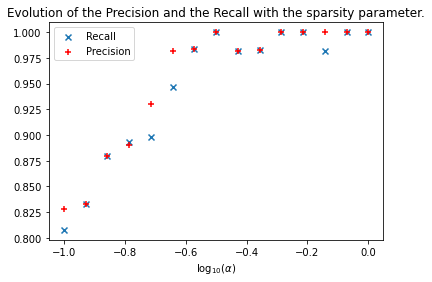

In [0]:
plt.scatter(np.log10(lsgamma),lsrecall, marker='x', label='Recall')
plt.scatter(np.log10(lsgamma),lsprecision, marker='+',c='red',label='Precision')
locs, labels = plt.xticks()
plt.xlabel('$\log_{10}(\\alpha)$')
plt.title('Evolution of the Precision and the Recall with the sparsity parameter.')
plt.legend()
plt.savefig('confusion_sparsity.png')
plt.show()

###### Consistency of the transition matrix


In [0]:
nb_experiments = 1
maxsize = 200
sizes = [i*20 for i in range(1,maxsize//20+1)]
results = {'nodes':[], 'norm':[], 'score':[]}
for n in sizes:
    for j in range(nb_experiments):
        G = SBM(n,K, framework='markov', P=P, Q=Q)
        G.estimate_partition()
        G.estimate_parameters()
        score = G.proportion_error()
        results['norm'].append(np.max(np.abs(G.approx_P-P)))
        results['nodes'].append(n)
        results['score'].append(score)


df = pd.DataFrame(results)
dflog = df.apply(np.log10)
ax = sns.lineplot(x="nodes", y="norm", err_style="bars", data=dflog)
ax.set_ylabel('$\log(\|\|\hat{P}-P\|\|_{\infty})$',fontsize=12)
ax.set_xlabel('$\log(n)$',fontsize=12)
ax.set_title('Consistency of the estimation of the transition matrix')
plt.legend()
plt.show()

### 4.2) $5$ communities

In [0]:
K = 5
P = np.array([[0.1, 0.3, 0.5,0.01, 0.09],[0.55, 0.15, 0.1, 0.05,0.15],[0.15, 0.3, 0.1, 0.2,0.25 ],[0.15, 0.05, 0.1, 0.5,0.2 ],[0.2,0.3,0.1,0.05,0.35]])
Q = np.array([[0.6, 0.1, 0.15, 0.1, 0.2 ],[0.2, 0.5, 0.35, 0.1, 0.4 ], [0.4, 0.15, 0.6, 0.25, 0.05], [0.4,0.1,0.1,0.2,0.55],[0.3,0.35,0.2,0.1,0.7]])

#### 4.2.1) Visualization of the matrices $\hat{B}$ and $B^*$

$$n=40$$

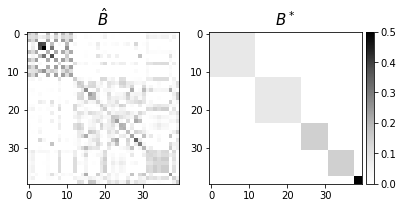

In [0]:
n = 40
G = SBM(n, K, framework='markov', P=P, Q=Q)
G.estimate_partition()
G.visualize_B_matrices()

$$n=160$$

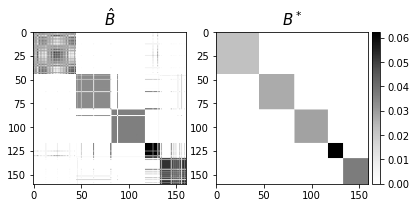

In [0]:
n = 160
G = SBM(n, K, framework='markov', P=P, Q=Q)
G.estimate_partition()
G.visualize_B_matrices()

#### 4.2.2) Recovery of hidden variables and parameter estimation

In [0]:
lsP = []
lsQ = []
lspi = []
lsscore = []
sizes = [40,60,80,100,120,140,160,180]
for n in sizes:
    G = SBM(n,K, framework='markov', P=P, Q=Q)
    G.estimate_partition()
    G.estimate_parameters()
    score= G.proportion_error()
    lsP.append(G.approx_P)
    lsQ.append(G.approx_Q)
    lspi.append(G.approx_pi)
    lsscore.append(score)

##### Missclassification error

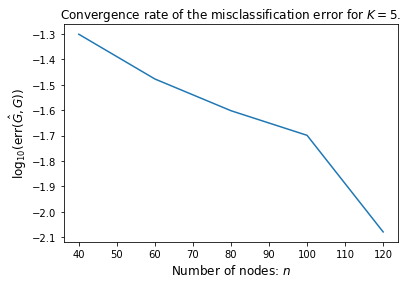

In [0]:
indmax = 0
while lsscore[indmax]>1e-9:
    indmax += 1
plt.plot(sizes[:indmax],np.log10(np.array(lsscore[:indmax])))
plt.ylabel('$ \log_{10}(\mathrm{err}(\hat{G},G))$',fontsize=12)
plt.xlabel('Number of nodes: $n$',fontsize=12)
plt.title('Convergence rate of the misclassification error for $K=5$.')
plt.show()

##### Consistency of the estimation of the transition and connectivity matrices


In [0]:
G = SBM(300, K, framework='markov', P=P, Q=Q)
infP = []
infQ = []
lsP = np.array(lsP)
for i in range(lsP.shape[0]):
    infP.append(np.max(np.abs(P-lsP[i])))
    infQ.append(np.max(np.abs(Q-lsQ[i])))

fig = plt.figure(figsize=(17,3))
ax = fig.add_subplot(1,2,1)
ax.plot(np.log10(sizes),np.log10(infP))
ax.set_ylabel('$ \log_{10}(\|\| \hat{P}-P\|\|_{\infty})$',fontsize=12)
ax.set_xlabel('$\log(n)$',fontsize=12)
ax.set_title('Consistency of the estimation of the transition matrix for $K=5$.')
ax = fig.add_subplot(1,2,2)
ax.plot(np.log10(sizes),np.log10(infQ))
ax.set_ylabel('$ \log_{10}(\|\| \hat{Q}-Q\|\|_{\infty})$',fontsize=12)
ax.set_xlabel('$\log(n)$',fontsize=12)
ax.set_title('Consistency of the estimation of the connectivity matrix for $K=5$.')
plt.show()